In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt
from CoExBO._utils import TensorManager
tm = TensorManager()
warnings.filterwarnings('ignore')

n_dims = 6                        # number of dimensions
dataset = "ranger"
seed = 3            # random seed for reproduce the results #SEED 8 rpart_preproc, SEED 3 for Ranger, SEED 1 for rpart, rpart_val: 5,

In [2]:
class Benchmark():
    def __init__(self, X_data, Y_data):
        self.X_data = X_data
        self.Y_data = Y_data
        
    def find_closest_point(self, query, loop = False):
        y_set = []
        query = query.squeeze()
        if len(query.shape) > 1:
            for X in query:
                X = X.detach().numpy()
                distances = np.linalg.norm(self.X_data - X, axis=1)
                closest_index = np.argmin(distances)
                #print(self.X_data[closest_index])
                #print(X)
                y = self.Y_data[closest_index]
                y_set.append(y)
            #print("y_set: ", y_set)
            return torch.tensor(y_set, dtype=torch.float32).squeeze()
        else:
            X = query.detach().numpy()
            distances = np.linalg.norm(self.X_data - X, axis=1)
            closest_index = np.argmin(distances)
            y = self.Y_data[closest_index]
            return torch.tensor(y, dtype=torch.float32)


In [3]:
lower_limit = 0
upper_limit = 1
colour_map = 'summer'
resolution = 200
ground_truth = torch.tensor([-1.02543108, -1.02543108])

## 2. Define domain
Next, we define the domain of interest.
We set domain as uniform distribution bounded -2 from 3.

In [4]:
import seaborn as sns
import pandas as pd

# set bounds

mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set domain
from CoExBO._prior import Uniform    # Import prior from SOBER libraries
domain = Uniform(bounds)


## 3. Preferential learning
Next, we try to learn the prior knowledge of human user.<br>
For simplicity, human selection process is automatically generated with 60% accuracy via simulation.

In [5]:
from CoExBO._coexbo import CoExBOwithSimulation, StateManager
n_init_pref = 100      # number of initial random samples for preferential learning
n_init_obj = 1        # number of initial random samples for objective function

## 4. Run CoExBO
Now, we will collaborate with BO for faster convergence.<br>

In [6]:
n_iterations = 50     # number of iterations
# initial setting
torch.manual_seed(seed)
state = StateManager(n_dims=n_dims)

In [7]:
from importlib.machinery import SourceFileLoader
def load_module(filename):
    module_name = os.path.splitext(os.path.basename(filename))[0]
    return SourceFileLoader(module_name, filename).load_module(module_name)

In [8]:
import yaml
model_type = 'tnpa'
model_cls = getattr(load_module(f'./models/{model_type}.py'), model_type.upper())
with open(f'configs/{dataset}/{model_type}.yaml', 'r') as f:
    config = yaml.safe_load(f)
#if args.model in ["np", "anp", "cnp", "canp", "bnp", "banp", "tnpa", "tnpd", "tnpnd"]:
model = model_cls(**config)
model.cuda()


TNPA(
  (embedder): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=64, out_features=64, bias=True)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (d

In [9]:
import os.path as osp
import torch
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.utils import t_batch_mode_transform
from CoExBO._utils import TensorManager

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results_path = './results/'
model_name = 'tnpa'
ckpt_path = osp.join(results_path, dataset, model_name, 'ckpt.tar')

ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt.model)

<All keys matched successfully>

In [10]:
import numpy as np
X_test = np.load(f'./datasets/{dataset}/X_test.npz')
y_test = np.load(f'./datasets/{dataset}/y_test.npz')
X_validation = np.load(f'./datasets/{dataset}/X_validation.npz')
y_validation = np.load(f'./datasets/{dataset}/y_validation.npz')

X_validation_ = np.array([X_validation[key].astype('float32') for key in X_validation.keys()])
y_validation_ = np.array([y_validation[key].astype('float32') for key in y_validation.keys()])


X_test_ = np.array([X_test[key].astype('float32') for key in X_test.keys()])
y_test_ = np.array([y_test[key].astype('float32') for key in y_test.keys()])

In [20]:
X_validation_[0]

AttributeError: 'numpy.ndarray' object has no attribute 'Type'

In [14]:
import numpy as np
import shap
xt = torch.tensor([[0.0043, 0.1056, 0.2858, 0.0270, 0.4716, 0.0601],[0.0043, 0.1056, 0.2858, 0.0270, 0.4716, 0.0601],[0.0043, 0.1056, 0.2858, 0.0270, 0.4716, 0.0601],[0.0043, 0.1056, 0.2858, 0.0270, 0.4716, 0.0601]]).cuda()
model.xc = torch.tensor([[[0,0,0,0,0,0]]]).cuda()
model.yc = torch.tensor([[[0]]]).cuda()
explainer = shap.KernelExplainer(model.predict_mean, X_validation_[0])
mean_shap = explainer.shap_values(xt[0].detach().cpu().numpy())

Using 115 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


self.xc.shape:  torch.Size([1, 1, 6])
MEAN SHAPE:  torch.Size([115])
DATA1 : [[0.0043 0.1056 0.2858 0.027  0.4716 0.0601]]
self.xc.shape:  torch.Size([1, 1, 6])
MEAN SHAPE:  torch.Size([1])
self.xc.shape:  torch.Size([1, 1, 6])
MEAN SHAPE:  torch.Size([7130])


<BarContainer object of 6 artists>

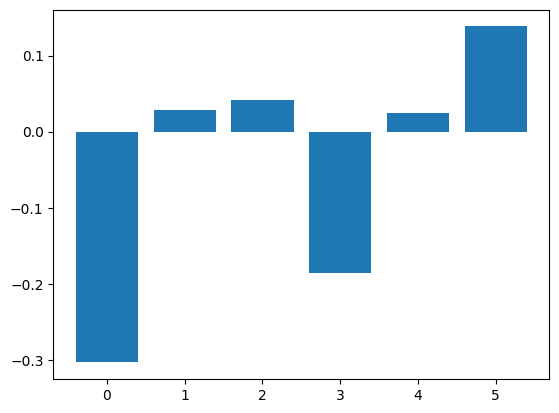

In [17]:
plt.bar(range(len(mean_shap)),mean_shap)

In [13]:
explainer = shap.KernelExplainer(model.predict_std, X_validation_[0])
explainer.shap_values(xt[0].detach().cpu().numpy())

Using 115 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


MEAN SHAPE:  torch.Size([115])
DATA1 : [[0.0043 0.1056 0.2858 0.027  0.4716 0.0601]]
MEAN SHAPE:  torch.Size([1])
MEAN SHAPE:  torch.Size([7130])


array([ 2.27804028e-03,  3.42092922e-05,  1.04051838e-03, -3.27963624e-04,
        3.48472083e-04,  1.04075380e-03])

In [13]:
sys.exit()

SystemExit: 

In [ ]:
results = []
import numpy as np
meta = True

X_test = np.load(f'./datasets/{dataset}/X_test.npz')
y_test = np.load(f'./datasets/{dataset}/y_test.npz')
X_validation = np.load(f'./datasets/{dataset}/X_validation.npz')
y_validation = np.load(f'./datasets/{dataset}/y_validation.npz')

X_validation_ = np.array([X_validation[key].astype('float32') for key in X_validation.keys()])
y_validation_ = np.array([y_validation[key].astype('float32') for key in y_validation.keys()])


X_test_ = np.array([X_test[key].astype('float32') for key in X_test.keys()])
y_test_ = np.array([y_test[key].astype('float32') for key in y_test.keys()])

best_values = []
total_trajectories = []
for i in range(len(X_test)):
    
    torch.random.manual_seed(seed)
    benchmark = Benchmark(X_test_[i], y_test_[i])
    # print(y_test[i])
    benchmark2 = Benchmark(X_validation_[i], X_validation_[i])
    true_function = benchmark.find_closest_point

    x_val = torch.rand(1, n_dims)
    print("X_VAL: ", x_val)
    y_val = true_function(x_val)
    dataset_obj = (x_val,y_val)
    
    true_function2 = benchmark.find_closest_point
    coexbo = CoExBOwithSimulation(domain, true_function, sigma=0.5, hallucinate=False, meta = meta)
    coexbo2 = CoExBOwithSimulation(domain, true_function2, sigma=0.5, hallucinate=False, meta = meta)
    #dataset_obj, _ = coexbo.initial_sampling(n_init_obj, n_init_pref)
    _, dataset_duel = coexbo.initial_sampling(n_init_obj, n_init_pref)
    
    # print("dataset_duel: ", dataset_duel)
    #print(dataset_duel)
    #_, dataset_duel = coexbo.initial_sampling(n_init_obj, n_init_pref)
    max_bv = -1
    trajectory = [y_val]
    for t in range(n_iterations):
        beta, gamma = state(t)
        #print("dataset_obj: ", dataset_obj[1])
        result, dataset_obj, dataset_duel = coexbo(
            dataset_obj, dataset_duel, beta, gamma, model_TPN = model, lower_limit= lower_limit, upper_limit=upper_limit
        )
        best_v = dataset_obj[1].max().item()
        if best_v > max_bv:
            max_bv = best_v
        trajectory.append(max_bv)
        print("Trajectory: ", trajectory)
        #print(f"{len(dataset_obj[0])}) Best value: {best_v:.5e}")
        results.append(result)
    total_trajectories.append(dataset_obj[1].detach().cpu().numpy())
    best_values.append(trajectory)
results = torch.tensor(results)

X_VAL:  

tensor([[0.0043, 0.1056, 0.2858, 0.0270, 0.4716, 0.0601]])
0) parameters: beta 1.697e+00 gamma 0.000e+00


KeyboardInterrupt: 

In [ ]:
import pickle
# Save the object as a pickle file
with open(f'evaluations/meta_{dataset}_3.pkl', 'wb') as file:
    pickle.dump(total_trajectories, file)

# Results
[overhead(s), best observation, Euclidean distance between the pairwise candidates, correct_answer_rate]

In [ ]:
best_values

[[tensor([0.1547]),
  0.5535723567008972,
  0.5535723567008972,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.6778167486190796,
  0.67781674